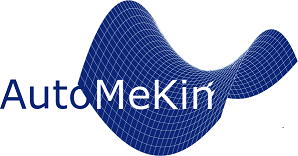
# Automated reaction Mechanisms and Kinetics



# Installing third-party packages

In [ ]:
%%capture
!pip install ase pubchempy numpy==1.26.4
!apt update
!apt install bc gawk gcc gfortran parallel sqlite3 cm-super dvipng texlive-latex-extra texlive-latex-recommended
%cd /opt/
!git clone https://github.com/dgarayr/amk_tools.git
%cd /opt/amk_tools
!pip install -e .

# Installing AutoMeKin

In [ ]:
%%capture
%cd /content/
!git clone https://github.com/emartineznunez/AutoMeKin.git
%cd /content/AutoMeKin
! autoreconf -i
!./configure --prefix=/opt/AutoMeKin
!make && make install
#We make use of the total number of processors
!sed -i 's@ignore=1@ignore=0@g' /opt/AutoMeKin/bin/utils.sh
%env PATH=".:/opt/amk_tools/scripts:/opt/AutoMeKin/bin:/opt/AutoMeKin/bin/HLscripts:/opt/AutoMeKin/bin/MOPAC_DEV:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin"
%env LIBRARY_PATH="/opt/AutoMeKin/lib:/opt/AutoMeKin/bin/MOPAC_DEV:/usr/local/cuda/lib64/stubs"
%env AMK=/opt/AutoMeKin
%env inter=0
%cd /content
!rm -rf /content/AutoMeKin

# Making the input files

In this example the default molecule is **formic acid (HCOOH)** and it takes a few minutes (<8). **If you want to change the molecule**, you can just pick one (by **cid**, **name**, **smiles**, **sdf**, **inchi**, **inchikey** or **formula**) from: https://pubchem.ncbi.nlm.nih.gov/

In [ ]:
#@title Choose the default, formic acid (FA) molecule, or a new system.
%%capture

%cd /content
!rm -rf test && mkdir test
%cd /content/test

import pubchempy as pcp

#Building the molecule

#The default is formic acid, but you might want another one https://pubchem.ncbi.nlm.nih.gov/
sel = input('This example is for \'formic acid\'.Do you want to choose your own molecule (y/n)?: ')
if sel == 'n':
  molecule = 'formic acid'
  nm = 'name'
else:
  nm = input('Identifier type: cid, name, smiles, sdf, inchi, inchikey, or formula: ')
  molecule = input('Type your molecule here: ')

query = pcp.get_compounds(molecule,nm,record_type='3d')
m = query[0]
f = open('mol.xyz','w')
f.write(str(len(m.atoms)) + '\n\n')
for i,a in enumerate(m.atoms): f.write(m.elements[i]+' '+str(a.x)+' '+str(a.y)+' '+str(a.z)+'\n')
f.close()

#Fetching input file template
!curl -L https://github.com/emartineznunez/AutoMeKin/raw/main/examples/FA.dat -o mol.dat
!sed -i 's@FA@mol@;s@imagmin 200@imagmin 50@' mol.dat

# Running the test
Running 3 iterations of the workflow with 5 tasks per iteration. Details of the program execution, input and output files, etc., can be looked up here: https://emartineznunez.github.io/AutoMeKin/docs/tutorial.html

In [ ]:
!llcalcs.sh mol.dat 5 3 2

*Transition-state structures found in these 3 iterations*

In [ ]:
!tsll_view.sh

*Convergence table*

In [ ]:
!cat FINAL_LL_mol/convergence.txt

*Coarse-grained reaction network*

In [ ]:
!cat FINAL_LL_mol/RXNet.cg

*Transition states and minima*

In [ ]:
!awk 'BEGINFILE {print "\n"}{print}' FINAL_LL_mol/TSinfo FINAL_LL_mol/MINinfo

*Kinetics: branching ratios and populations*

In [ ]:
#Printing branching ratios and reading the csv file to plot the population vs time
%cd /content/test
#!awk '{print $0};NF==0{exit}' FINAL_LL_mol/kineticsE150
#!awk '/Time/,0 {for(i=1;i<=NF-1;i++) printf "%s, ",$i;print $NF}' FINAL_LL_mol/kineticsE150 > FINAL_LL_mol/kinetics.csv

# importing libraries and creating the plot
import pandas as pd
from matplotlib import pyplot

pyplot.rcParams['text.usetex'] = True
pyplot.xticks(fontsize=14)
pyplot.yticks(fontsize=14)

data = pd.read_csv('FINAL_LL_mol/kinetics.csv')
for count,col in enumerate(data.columns):
  if count == 0:
    x=data[col]
    xcol=col
  if count >=1: pyplot.plot(x,data[col],label=col,linewidth=1.0)

pyplot.ylabel('Population',fontsize=20)
pyplot.xlabel(xcol,fontsize=20)

pyplot.legend()
pyplot.xlim(0,max(x))
pyplot.ylim(0,1000)
pyplot.tight_layout()
pyplot.savefig('/content/test/kinetics.png')
pyplot.show()

*Generate network.html for visualization*

In [ ]:
from os import path

%cd /content/test
if path.isfile('tsdirLL_mol/KMC/starting_minimum'): tag = !awk 'NR=1{print $1}' tsdirLL_mol/KMC/starting_minimum
else: tag = [1]
!amk_gen_view.py FINAL_LL_mol RXNet.cg --b --paths MIN{tag[0]}
!mkdir HTML
!mv network.html HTML
%cd /content/test/HTML

In [ ]:
# @title ##### _Open the file network.html_
import IPython
from IPython.core.magic import register_line_magic
import subprocess

@register_line_magic
def run_local_server(line):
    handle = IPython.display.display(
            IPython.display.Pretty("Launching my server..."),
            display_id=True,
    )
    subprocess.Popen(['python', '-m', 'http.server'])
    shell = """
        (async () => {
            const url = new URL(await google.colab.kernel.proxyPort(8000, {'cache': true}));
            const iframe = document.createElement('iframe');
            iframe.src = url;
            iframe.setAttribute('width', '100%');
            iframe.setAttribute('height', '800');
            iframe.setAttribute('frameborder', 0);
            document.body.appendChild(iframe);
        })();
    """
    script = IPython.display.Javascript(shell)
    handle.update(script)
!fuser -k 8000/tcp
%run_local_server

*Statistics of the reaction network*

In [ ]:
%cd /content/test
!amk_rxn_stats.py FINAL_LL_mol
%cat rxn_stats.txt